In [765]:
import pandapower as pp
import pandapower.networks as nw
import numpy as np

## Netowork Overview
Loading IEEE 30 bus system to test

In [783]:
net = nw.case30()
print(net)
print(f"Total Capacity in MW : {net.gen.max_p_mw.sum()}") #Total Capacity
print(f"Total Load in MW : {net.load.p_mw.sum()}") #Total Load
zone1 = net.bus.zone.loc[net.bus.zone==1]
tot_zone1 = (zone1.sum())/1
zone2 = net.bus.zone.loc[net.bus.zone==2]
tot_zone2 = (zone2.sum())/2
zone3 = net.bus.zone.loc[net.bus.zone==3]
tot_zone3 = (zone3.sum())/3
print(f"Total Bus in Zone 1 : {tot_zone1},",f"Zone 2 : {tot_zone2},", f"Zone 3 :{tot_zone3}")

This pandapower network includes the following parameter tables:
   - bus (30 elements)
   - load (20 elements)
   - gen (5 elements)
   - shunt (2 elements)
   - ext_grid (1 element)
   - line (41 elements)
   - poly_cost (6 elements)
   - bus_geodata (30 elements)
Total Capacity in MW : 255.0
Total Load in MW : 189.2
Total Bus in Zone 1 : 11.0, Zone 2 : 10.0, Zone 3 :9.0


## Visualizing the network
Plotting the network including bus labels, gens, and loads.

In [784]:
def plot_net(net, ax=None):
    if ax is None:
        fig, ax = mpl.subplots(1, 1, figsize=(10, 8))

    sizes = get_collection_sizes(net)

    # create collections for elements
    collections = list()
    collections.append(plt.create_bus_collection(net, size=sizes["bus"]))
    collections.append(plt.create_line_collection(net, use_bus_geodata=True))
    #collections.append(plt.create_trafo_collection(net, size=sizes["trafo"]))
    collections.append(plt.create_ext_grid_collection(net, size=sizes["ext_grid"], orientation=1.5))
    collections.append(plt.create_gen_collection(net, size=sizes["gen"], orientation=1))
    collections.append(plt.create_bus_bus_switch_collection(net, size=sizes["switch"]))
    collections.append(plt.create_line_switch_collection(net, distance_to_bus=sizes["switch_distance"], size=sizes["switch"]))
    collections.append(plt.create_load_collection(net, size=sizes["load"]))

    # add labels for each bus
    for idx in net.bus_geodata.index:
        x = net.bus_geodata.loc[idx, "x"]
        y = net.bus_geodata.loc[idx, "y"] + sizes["bus"] * 1.
        ax.text(x, y, str(idx), fontsize=12, color="r")

    plt.draw_collections(collections, ax=ax)
    mpl.tight_layout()

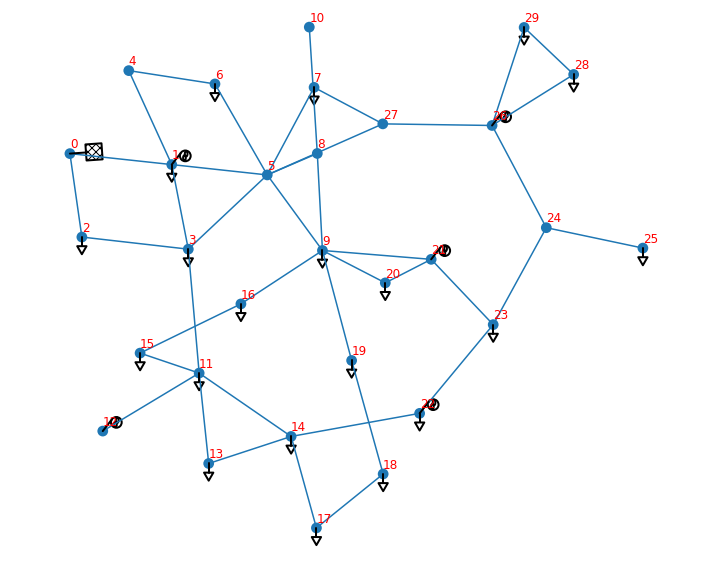

In [785]:
plot_net(net)

## Power Flow
Running a pf and checking which line has loading percent > 90. Result indicates that line between bus 5 to bus 7 is >100 %, and bus 20 to bus 21 > 90%

In [787]:
pp.runpp(net)
print(f"Lines with more than 90% Loading Percent: \n {net.res_line.loading_percent.loc[net.res_line.loading_percent>90]}")

Lines with more than 90% Loading Percent: 
 9     111.831406
28     95.350986
Name: loading_percent, dtype: float64


## Gen Contingency
Now, we take out the $5$ gens one by one and check the powerflow results again. We can see that, for most cases, the critical lines are same as before, in addition to some extended loading percentage. Some changes are visible such as, when we lost the Gen in Bus $21$, we no longer observe critical lines between bus $20$ to bus $21$. However, we can see that the line between Bus $23$ to Bus $24$ is approaching towards critical conditions. Finally, when we lost the Gen in Bus $12$, we get a new candidate. We see that the line loading percent between Bus $14$ to Bus $22$ is $> 100$.

In [771]:
gens = net.gen.index
max_ll = 90.
for l in gens:
    net.gen.loc[l, "in_service"] = False
    pp.runpp(net)
    if net.res_line.loading_percent.max() > max_ll:
        critical.append(l)
        print(net.res_line.loading_percent.loc[net.res_line.loading_percent>max_ll])
    net.gen.loc[l, "in_service"] = True

9     112.227488
28    102.814560
Name: loading_percent, dtype: float64
9     114.156414
31     93.705973
Name: loading_percent, dtype: float64
9     125.171379
28     94.513745
Name: loading_percent, dtype: float64
9     113.268596
28     93.602440
Name: loading_percent, dtype: float64
9     113.375455
28     99.847862
29    102.687185
Name: loading_percent, dtype: float64


### Printing Critical Lines
Now, we will observe the critical lines from the above result and check the bus with the associated lines.

In [773]:
net.line.loc[[9,28,29,31,39,40]]

,c_nf_per_km,df,from_bus,g_us_per_km,in_service,length_km,max_i_ka,max_loading_percent,name,parallel,r_ohm_per_km,std_type,to_bus,type,x_ohm_per_km
9,0.000000,1.0,5,0.0,True,1.0,0.136853,100.0,None,1,1.8225,None,7,ol,7.2900
28,0.000000,1.0,20,0.0,True,1.0,0.136853,100.0,None,1,1.8225,None,21,ol,3.6450
29,0.000000,1.0,14,0.0,True,1.0,0.068427,100.0,None,1,18.2250,None,22,ol,36.4500
31,0.000000,1.0,22,0.0,True,1.0,0.068427,100.0,None,1,23.6925,None,23,ol,49.2075
39,291.092717,1.0,7,0.0,True,1.0,0.136853,100.0,None,1,10.9350,None,27,ol,36.4500
40,145.546359,1.0,5,0.0,True,1.0,0.136853,100.0,None,1,3.6450,None,27,ol,10.9350


### Zones Overview
Now, we will check which buses are connected to which zones.

In [774]:
print(net.bus.zone.loc[net.bus.zone==1])
print(net.bus.zone.loc[net.bus.zone==2])
print(net.bus.zone.loc[net.bus.zone==3])

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
10    1.0
27    1.0
Name: zone, dtype: object
11    2.0
12    2.0
13    2.0
14    2.0
15    2.0
16    2.0
17    2.0
18    2.0
19    2.0
22    2.0
Name: zone, dtype: object
9     3.0
20    3.0
21    3.0
23    3.0
24    3.0
25    3.0
26    3.0
28    3.0
29    3.0
Name: zone, dtype: object


## Adding Spinning Reserve
Now, we will observe the effect of having a reserve. Clearly, from the system diagram above, lines between Bus 5, 7, & 27 are critical as the max load of the system is at Bus 7. So, logically, adding a local supply to Bus 7 should minimize the loading percent.
#### Zone 1 reserve: Promising case: Bus 7
#### Zone 2 reserve: No promising case
#### Zone 3 reserve: No promising case
So, we will take the solution from Zone 1 reserve. We will see that there is no line that's taking more than 100% load.

In [775]:
max_ll = 85.
net1=nw.case30()
pp.create_sgen(net1, 7, p_mw=30, type='WP', name='Wind Park', in_service= True)
pp.runpp(net1)
if net1.res_line.loading_percent.max() > max_ll:
    print(f"PF result by adding a reserve : \n {net1.res_line.loading_percent.loc[net1.res_line.loading_percent>max_ll]}")
    

PF result by adding a reserve : 
 28    92.594675
Name: loading_percent, dtype: float64


### Reserve in Generator Contingency
Now, we will see how having the reserve mitigates the problem while having generator contingency.
We will observe that losing the generator in Bus 12 is causing line overload between Bus 14-22. Apart from that, having the reserve at Bus 7 tackles most of the contingency.

In [778]:
gens = net1.gen.index
max_ll = 90.
for i in gens:
    net1.gen.loc[i, "in_service"] = False
    pp.runpp(net1)
    if net1.res_line.loading_percent.max() > max_ll:
        print(f"PF result with reserve & contingency : \n {net1.res_line.loading_percent.loc[net1.res_line.loading_percent>max_ll]}")
    net1.gen.loc[i, "in_service"] = True

PF result with reserve & contingency : 
 28    98.86795
Name: loading_percent, dtype: float64
PF result with reserve & contingency : 
 31    90.7566
Name: loading_percent, dtype: float64
PF result with reserve & contingency : 
 28    91.006164
Name: loading_percent, dtype: float64
PF result with reserve & contingency : 
 28    90.359603
Name: loading_percent, dtype: float64
PF result with reserve & contingency : 
 28     96.471211
29    101.832165
Name: loading_percent, dtype: float64


### Using Reserve only during contingency
We will add another small reserve to mitigate the overload when we lose the gen at Bus 12. This reserve will only active in terms of a violation in line loading. This addition clearly solves the ongoing issue.

In [779]:
net2=nw.case30()
pp.create_sgen(net2, 7, p_mw=30, type='WP', name='Wind Park', in_service= True) #Always in service
pp.create_sgen(net2, 14, p_mw=2, type='WP', name='Wind Park', in_service= False) #Service only in contingency
pp.runpp(net2)
if net2.res_line.loading_percent.max() > max_ll:
    print(f"PF result before reserve : \n {net2.res_line.loading_percent.loc[net2.res_line.loading_percent>max_ll]}")

PF result before reserve : 
 28    92.594675
Name: loading_percent, dtype: float64


Just adding a small reserve of 2 MW solves the issue. We can even improve the loading percentage by increasing the MW reserve upto 30-35 MW.

In [781]:
gens = net2.gen.index
max_ll = 99.
for i in gens:
    net2.gen.loc[i, "in_service"] = False
    pp.runpp(net2)
    if net2.res_line.loading_percent.max() > max_ll:
        print(f"PF result without using reserve during contingency: \n {net2.res_line.loading_percent.loc[net2.res_line.loading_percent>max_ll]}")
        net2.sgen.loc[1,"in_service"] = True
        pp.runpp(net2)
        if net2.res_line.loading_percent.max() > max_ll:
            print(f"PF result with reserve in contingency : \n {net2.res_line.loading_percent.loc[net2.res_line.loading_percent>max_ll]}")
        net2.sgen.loc[1,"in_service"] = False
    net2.gen.loc[i, "in_service"] = True

PF result without using reserve during contingency: 
 29    101.832165
Name: loading_percent, dtype: float64
PF result with reserve in contingency : 
 29    99.02616
Name: loading_percent, dtype: float64


## Reserve Undeliverable
From the above trial and error, we can say that reserve is not deliverable for most of the cases. In our selected bus, it's a good one for most of the region. We can also observe that adding reserve to other bus instead of Bus 7, does not solve the overload issue between Bus 5-7-27. So, reserve is not deliverable for the other case.

### Validating the result with Sensitivity Matrix (Pending)
The trial and error method can take too much time and having an intuitive mathematical alternative is the best solution. The jacobian Matrix J in the last iteration step and can be accessed. We know that the inverse of the jacobian matrix gives us the sensitivity matrix.

In [788]:
gen_buses = net.gen.loc[net.gen.in_service.values, "bus"].values
print(f"pandapower gen bus: {gen_buses}")
J = net._ppc["internal"]["J"]
print(f"Jacobian shape: {J.shape}")
J_ar = net._ppc["internal"]["J"].todense() #Jacobian Matrix
J_inv = np.linalg.inv(J_ar) #Jacobian Inverse
np.shape(J_inv)

pandapower gen bus: [ 1 21 26 22 12]
Jacobian shape: (53, 53)


(53, 53)

### Obtaining Jacobian Entries of Generators
Why has the Jacobian the shape 53x53? It consists of the partial derivatives J11 = dP_dVa, J12 = dP_Vm, J21 = dQ_dVa, J22 = dQ_dVm. Except the reference bus, all PV- and PQ-buses are included in J. Vm is constant for PV nodes and dS/dVm is 0 for PV-buses (gens in pandapower) and Q is a variable.

This is the reason why J11 to J22 have these shapes:

J11 = pvpq x pvpq (dP_dVa)

J12 = pvpq x pq (dP_dVm)

J21 = pq x pvpq (dQ_dVa)

J22 = pq x pq (dQ_dVm)

Only J11 contains values relevant for gens.

In [764]:
import numpy as np

# get pv and pq values from newtonpf()
pv = net._ppc["internal"]["pv"]
pq = net._ppc["internal"]["pq"]
# stack these as done in newtonpf()
pvpq = np.hstack((pv, pq))

print("pv and pq nodes as in the newtonpf() function")
print(f"pv buses: {pv}\npq buses: {pq}\npvpq buses: {pvpq}")

# get len of pv and pq
n_pvpq = len(pvpq)
n_pq = len(pq)
n_pv = len(pv)
# get J11, J12, J21, and J22
j11 = J_inv[:n_pvpq, :n_pvpq]
j12 = J_inv[:n_pvpq, n_pvpq:]
j21 = J_inv[n_pvpq:, :n_pvpq]
j22 = J_inv[n_pvpq:, n_pvpq:]

print("shape of J sub-matrices:")
print(f"j11 = {j11.shape}")
print(f"j12 = {j12.shape}")
print(f"j21 = {j21.shape}")
print(f"j22 = {j22.shape}")
m = np.isin(pvpq, pv)
n = m
j11_gen_entries = j11[m, n]
#print(f"J11 indices: m = {m}, n = {n}")
print(f"pandapower gen {gen_buses} entries (ppc PV nodes {ppc_gen_buses}) in J11 (=dP/dVa): {j11_gen_entries}")

pv and pq nodes as in the newtonpf() function
pv buses: [ 1 12 21 22 26]
pq buses: [ 2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 23 24 25 27 28 29]
pvpq buses: [ 1 12 21 22 26  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 23
 24 25 27 28 29]
shape of J sub-matrices:
j11 = (29, 29)
j12 = (29, 24)
j21 = (24, 29)
j22 = (24, 24)
pandapower gen [ 1 21 26 22 12] entries (ppc PV nodes [ 1 21 26 22 12]) in J11 (=dP/dVa): [[0.05590609 0.39677489 0.28537183 0.40923207 0.42041953]]


### OPF
We run an OPF and check the cost

In [790]:
pp.runopp(net, delta=1e-16)
net.res_cost

578.4861906601212

In [791]:
net.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,ext_grid,0.0,2.00,0.02000,0.0,0.0,0.0
1,0,gen,0.0,1.75,0.01750,0.0,0.0,0.0
2,1,gen,0.0,1.00,0.06250,0.0,0.0,0.0
3,2,gen,0.0,3.25,0.00834,0.0,0.0,0.0
4,3,gen,0.0,3.00,0.02500,0.0,0.0,0.0
5,4,gen,0.0,3.00,0.02500,0.0,0.0,0.0


### Adding cost manually to the reserve
We can add cost manually to the added reserve and observe the result for different cost

In [883]:
net1=nw.case30()
pp.create_sgen(net1, 7, p_mw=30, type='WP', name='Wind Park', in_service= True)
pp.create_poly_cost(net1, 0, 'sgen', 8)

6

In [884]:
net1.poly_cost
pp.runopp(net1, delta=1e-16)
print(net1.res_cost)

461.92481895249205


### Analysis of the result
Since the added reserve is at the same bus as the load, it's acting as a local supply and the loading percentage limit for each line is at 100%, which is clearly optimal from the pf result above. So, we are observing a reduced cost for using the added source. It's also adding to the total capacity.

### Cost during different Contingency
We can observe the variation of cost for different contingency

In [893]:
gens = net1.gen.index
max_ll = 90.
print(f"Cost at different contingency : \n")
for i in gens:
    net1.gen.loc[i, "in_service"] = False
    pp.runopp(net1, delta=1e-16)
    print(net1.res_cost)
    #if net1.res_line.loading_percent.max() > max_ll:
        #print(f"PF result with reserve & contingency : \n {net1.res_line.loading_percent.loc[net1.res_line.loading_percent>max_ll]}")
    net1.gen.loc[i, "in_service"] = True

Cost at different contingency : 

522.8558267887092
494.94654943069145
470.94930074540486
467.74893667027584
468.48329214465525


### Cost for adding reserve during contingency
We will observe less cost for using SGEN due to local supply

In [894]:
net2=nw.case30()
pp.create_sgen(net2, 7, p_mw=30, type='WP', name='Wind Park', in_service= True)
pp.create_sgen(net2, 14, p_mw=2, type='WP', name='Wind Park', in_service= False)
pp.create_poly_cost(net2, 0, 'sgen', 5)
pp.create_poly_cost(net2, 1, 'sgen', 10)

7

In [895]:
gens = net2.gen.index
max_ll = 98.
for i in gens:
    net2.gen.loc[i, "in_service"] = False
    pp.runpp(net2)
    pp.runopp(net2)
    print(f"Cost without SGEN: {net2.res_cost}")
    if net2.res_line.loading_percent.max() > max_ll:
        net2.sgen.loc[1,"in_service"] = True
        pp.runpp(net2)
        pp.runopp(net2)
        print(f"Cost with SGEN: {net2.res_cost}")
        net2.sgen.loc[1,"in_service"] = False
    net2.gen.loc[i, "in_service"] = True

Cost without SGEN: 522.8555748259124
Cost with SGEN: 514.6191942826828
Cost without SGEN: 494.94693474751597
Cost without SGEN: 470.9493219237919
Cost without SGEN: 467.74892249431036
Cost without SGEN: 468.4831424765926
